In [83]:
from autograd import elementwise_grad as egrad
from autograd import jacobian
import autograd.numpy as np
import scipy.stats as sps

from sklearn.datasets import make_classification

from scipy.optimize import minimize

In [90]:
def gen_f(a, b, l):
    def func(x):
        return l * np.linalg.norm(x) ** 2 + np.log(1.0 + np.exp(-b * (a * x).sum()))

    return func

def gen_grad_f(a, b, l):
    def grad(x):
        return 2 * l * x - b * a / (1.0 + np.exp(b * (a * x).sum()))
    
    return grad

def gen_jacobian_f(a, b, l):
    def jacobian(x):
        ans = np.zeros((x.size, x.size))
        
        for i in range(x.size):
            for j in range(x.size):
                ans[i][j] = 2 * l * (i == j) + b**2 * np.exp(b * (a * x).sum()) / \
                            (1.0 + np.exp(b * (a * x).sum()))**2 * a[j] * a[i]
        
        return ans # 2 * l * x - b * a / (1.0 + np.exp(b * (a * x).sum()))
    
    return jacobian

In [91]:
N = 500
d = 5

As, bs = make_classification(n_samples = N, n_features=d)

def gen_funcs(l):
    F = [gen_f(a, b*2 - 1.0, l) for a, b in zip(As, bs)]
    grad_F = [gen_grad_f(a, b*2 - 1.0, l) for a, b in zip(As, bs)]
    jacobian_F = [gen_jacobian_f(a, b*2 - 1.0, l) for a, b in zip(As, bs)]
    
    
    def FF(x):
        return np.array([f(x) for f in F]).mean()
    def grad_FF(x):
        return np.array([grad_f(x) for grad_f in grad_F]).sum(axis=0)
    return F, grad_F, jacobian_F, FF, grad_FF

In [92]:
def get_init(FF, grad_FF):
    lambd = 0.0001

    x0 = np.ones(d)

    for _ in range(30):
        grad = grad_FF(x0)
        x0 -= lambd * grad

#     print(x0, FF(x0))

    W_init = np.array([x0 for _ in range(N)])
    x_opt = minimize(FF, np.ones(d))
    return W_init, x_opt

In [93]:
class SN:
    def __init__(self, W_init, batch_sz, grad_F, jacobian_F, x_init):
        self.grad_f = grad_F
        self.jacobian_f = jacobian_F
        self.n = W_init.shape[0]
        self.W = W_init
        self.batch_sz = batch_sz
        self.x = x_init # np.zeros(W_init.shape[1])
        self.Hs = np.array([jacobian_f(w) for w, jacobian_f in zip(self.W, self.jacobian_f)])
        self.grad = np.array([grad_f(w) for w, grad_f in zip(self.W, self.grad_f)])

    def generate_S(self):
        return sps.randint(0, self.n).rvs(size=self.batch_sz)

    def make_step(self):
        M = None
        H_ = None
        
        for i in range(self.n):
            H = self.Hs[i]
            w = self.W[i]
            gr = 1 * self.grad[i]

            if M is None:
                M = H.dot(w) - gr
                H_ = H
            else:
                M = M + H.dot(w) - gr
                H_ = H_ + H
        M = M / self.n
        H = H_ / self.n

        self.x = np.linalg.inv(H).dot(M)

        S = self.generate_S()

        self.W[S] = self.x
        for i in S:
            self.Hs[i] = (self.jacobian_f[i])(self.W[i])
            self.grad[i] = (self.grad_f[i])(self.W[i])

In [94]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:

data = []
for batch in [1, 2, 4, 8]:
    for l in [0.1, 0.001, 0.0001]:  
        F, grad_F, jacobian_F, FF, grad_FF = gen_funcs(l)
        W_init, x_opt = get_init(FF, grad_FF)

        A0 = np.abs(x_opt.fun - FF(W_init[0]))
#         print(A0)
        sn = SN(W_init, batch, grad_F, jacobian_F, W_init[0])
        for i in (range(100)):
            sn.make_step()
            data.append((batch, i, l, np.abs(FF(sn.x) - x_opt.fun)/A0))
#     print(i, end='.')


In [98]:
df = pd.DataFrame(data, columns=['batch_size', 'iter', 'lambda', 'Ak/A0'])
df.to_csv('data.csv')

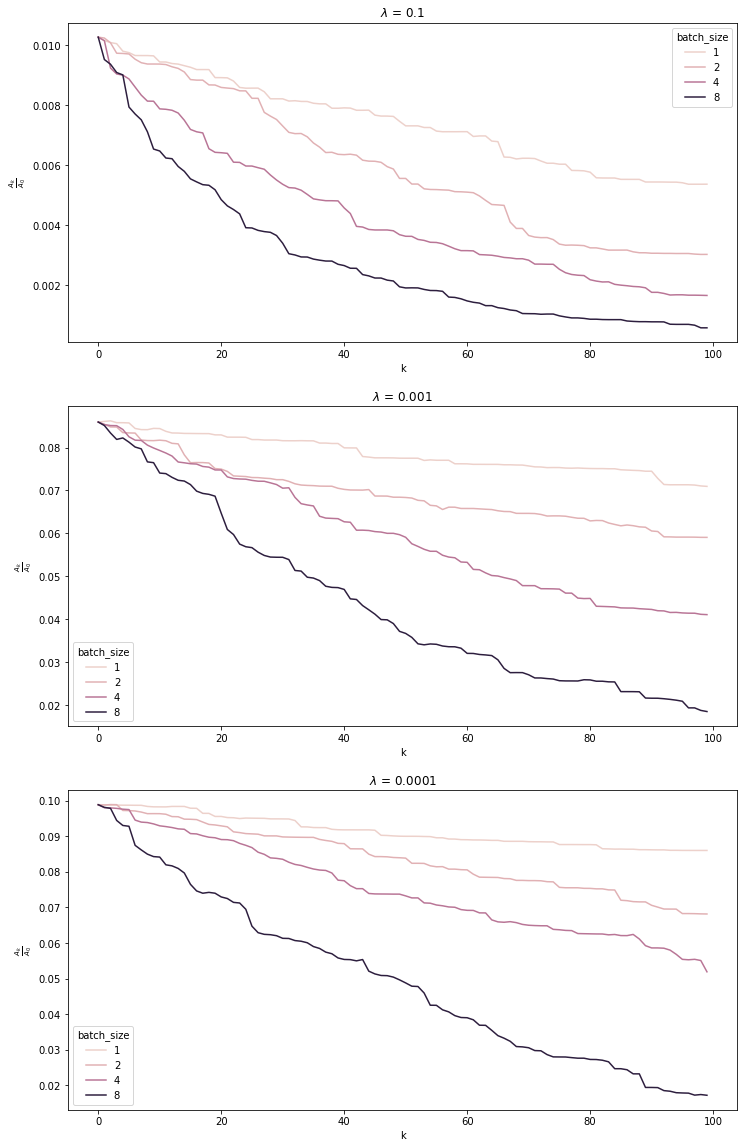

In [101]:
df = pd.DataFrame(data, columns=['batch_size', 'iter', 'lambda', 'Ak/A0'])
df.to_csv('data2.csv')

plt.figure(figsize=(12, 20))

for i, l in enumerate([0.1, 0.001, 0.0001]):
    plt.subplot(3, 1, i + 1)
    subdata = df[df['lambda'] == l]
#     del subdata['lambda']
    sns.lineplot(data=subdata, x='iter', y='Ak/A0', hue='batch_size')

    plt.title(fr'$\lambda$ = {l}')
    plt.xlabel('k')
    plt.ylabel(r'$\frac{A_k}{A_0}$')

plt.savefig('plot.png')